## Incorporate a seasonal dependence on Mn concentrations in rivers

For one of the experiments in this chapter, I will test how significant incorporating a seasonal cycle in riverine Mn concentrations is. This is based on Manuel Colombo's estimates of potential maximum Mn concentrations during peak flow (in Colombo et al., 2019). 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import datetime as dt
import pickle
import xarray as xr
import netCDF4 as nc
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### Parameters:

In [4]:
color_glac = '#0873b4'
color_cont = '#ab5c29'
color_other= '#757575'

#### Functions

In [5]:
def read_discharge(file, envcan=False):
    
    if envcan:
        file_data = pd.read_csv(file_Marcil, skiprows=1)
        dates     = pd.to_datetime(file_data['Date'])
        discharge = file_data['Value']
    else:
        file_data = pd.read_csv(file)
        dates     = pd.to_datetime(file_data['date'])
        discharge = file_data['discharge']
    
    return dates, discharge

In [6]:
def find_nearest_date(shorter_array, longer_array):
    idx = []
    for date in shorter_array:
        diff = np.abs(longer_array - date)
        idx.append(diff.idxmin())
    
    return idx

In [7]:
def plot_seasonal_cycle(ax, Mn_river, dates_river, river_discharge, dates_discharge, discharge=False):

    for mth in range(1,13):
        # Plot the dissolved Mn seasonal cycle
        dates = dates_river[dates_river.dt.month == mth]
        Mn   = Mn_river[dates_river.dt.month == mth]

        date_array = [pd.to_datetime(f'2005-{date.month}-{date.day}') for date in dates]
      
        ax.plot(date_array, Mn, '.w', markersize=25, markeredgecolor='k', zorder=3, label='_Hidden')

        # Also plot the discharge seasonal cycle
        if discharge:
            dates_Q = dates_discharge[dates_discharge.dt.month == mth]
            Q       = river_discharge[dates_discharge.dt.month == mth]
            
            if mth==2:
                dates_Q[dates_Q.dt.day > 28] = dt.datetime(2005,2,28)
                
            try:
                date_array_Q = [pd.to_datetime(f'2005-{date.month}-{date.day}') for date in dates_Q]
                ax.plot(date_array_Q, Q, '.k', markersize=1, zorder=1, label='_Hidden')   
            except:
                pass
        
    return

In [8]:
def plot_Qseasonal_cycle(ax, river_discharge, dates_discharge, color='k', size=2):

    for mth in range(1,13):
        dates_Q = dates_discharge[dates_discharge.dt.month == mth]
        Q       = river_discharge[dates_discharge.dt.month == mth]
            
        if mth==2:
            dates_Q[dates_Q.dt.day > 28] = dt.datetime(2005,2,28)
                
        try:
            date_array_Q = [pd.to_datetime(f'2005-{date.month}-{date.day}') for date in dates_Q]
            ax.plot(date_array_Q, Q, '.', c=color, markersize=size, markeredgecolor='k', zorder=2, label='_Hidden')   
        except:
            pass
        
    return

In [9]:
def normalize(variable):
    
    norm_variable = variable/np.amax(variable)
    
    return norm_variable

### Parameters

In [10]:
# domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799

### Load files

In [11]:
file_model = nc.Dataset('/ocean/brogalla/GEOTRACES/data/runoff/ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y2015.nc')
model_lons  = np.array(file_model.variables['nav_lon'])
model_lats  = np.array(file_model.variables['nav_lat'])
model_river = np.array(file_model.variables['runoff'])

In [12]:
# Environment Canada Hydrographic Data:
file_Marcil = '/ocean/brogalla/GEOTRACES/data/Daily__Marcil_Creek-10UB001.csv'
file_Allen  = '/ocean/brogalla/GEOTRACES/data/Daily__Allen_River-10VC001.csv'
file_Mecham = '/ocean/brogalla/GEOTRACES/data/Daily__Mecham_River-10VC002.csv'

In [13]:
Marcil_dates, Marcil_discharge = read_discharge(file_Marcil, envcan=True)
Allen_dates , Allen_discharge  = read_discharge(file_Allen , envcan=True)
Mecham_dates, Mecham_discharge = read_discharge(file_Mecham, envcan=True)

Discharge and trace metal data files from the Arctic Great Rivers Observatory

In [14]:
discharge_file_Mack   = '/ocean/brogalla/GEOTRACES/data/rivers/Mackenzie_Arctic_Red_River_1972_2020.csv'
discharge_file_Kolyma = '/ocean/brogalla/GEOTRACES/data/rivers/Kolyma_Kolymskoe_1978_2020.csv'
discharge_file_Lena   = '/ocean/brogalla/GEOTRACES/data/rivers/Lena_Kyusyur_1936_2020.csv'
discharge_file_Ob     = '/ocean/brogalla/GEOTRACES/data/rivers/Ob_Salekhard_1936_2020.csv'
discharge_file_Yeni   = '/ocean/brogalla/GEOTRACES/data/rivers/Yenisei_Igarka_1936_2020.csv'
discharge_file_Yukon  = '/ocean/brogalla/GEOTRACES/data/rivers/Yukon_Pilot_Station_1975_2020.csv'

tracer_file    = '/ocean/brogalla/GEOTRACES/data/rivers/AGRO_river_tracers.csv'

In [15]:
Mack_dates  , Mack_discharge   = read_discharge(discharge_file_Mack)
Kolyma_dates, Kolyma_discharge = read_discharge(discharge_file_Kolyma)
Lena_dates  , Lena_discharge   = read_discharge(discharge_file_Lena)
Ob_dates    , Ob_discharge     = read_discharge(discharge_file_Ob)
Yeni_dates  , Yeni_discharge   = read_discharge(discharge_file_Yeni)
Yukon_dates , Yukon_discharge  = read_discharge(discharge_file_Yukon)

In [16]:
tracers        = pd.read_csv(tracer_file)

Kolyma_dates_tracers   = pd.to_datetime(tracers['date'][0:8])
Lena_dates_tracers     = pd.to_datetime(tracers['date'][8:23])
Mack_dates_tracers     = pd.to_datetime(tracers['date'][23:37])
Ob_dates_tracers       = pd.to_datetime(tracers['date'][37:52])
Yenisey_dates_tracers  = pd.to_datetime(tracers['date'][52:65])
Yukon_dates_tracers    = pd.to_datetime(tracers['date'][65:80])

Mn_Kolyma      = tracers['Mn (nM)'][0:8]
Mn_Lena        = tracers['Mn (nM)'][8:23]
Mn_Mack        = tracers['Mn (nM)'][23:37]
Mn_Ob          = tracers['Mn (nM)'][37:52]
Mn_Yenisey     = tracers['Mn (nM)'][52:65]
Mn_Yukon       = tracers['Mn (nM)'][65:80]

TSS_Kolyma     = tracers['TSS (mg/L)'][0:8]
TSS_Lena       = tracers['TSS (mg/L)'][8:23]
TSS_Mack       = tracers['TSS (mg/L)'][23:37]
TSS_Ob         = tracers['TSS (mg/L)'][37:52]
TSS_Yenisey    = tracers['TSS (mg/L)'][52:65]
TSS_Yukon      = tracers['TSS (mg/L)'][65:80]

In [17]:
# Smaller Arctic rivers data:
coppermine_dates, coppermine_discharge = pickle.load(open('/ocean/brogalla/GEOTRACES/data/rivers/coppermine_data.pickle','rb'))
burnside_dates, burnside_discharge     = pickle.load(open('/ocean/brogalla/GEOTRACES/data/rivers/burnside_data.pickle','rb'))
ellice_dates, ellice_discharge         = pickle.load(open('/ocean/brogalla/GEOTRACES/data/rivers/ellice_data.pickle','rb'))

## Calculations

In [18]:
# Normalized Mn concentrations:
Mn_Mack_norm    = Mn_Mack    / np.amax(Mn_Mack)
Mn_Kolyma_norm  = Mn_Kolyma  / np.amax(Mn_Kolyma)
Mn_Lena_norm    = Mn_Lena    / np.amax(Mn_Lena)
Mn_Ob_norm      = Mn_Ob      / np.amax(Mn_Ob)
Mn_Yenisey_norm = Mn_Yenisey / np.amax(Mn_Yenisey)
Mn_Yukon_norm   = Mn_Yukon   / np.amax(Mn_Yukon)

Identify discharge nearest to trace metal measurement date:

In [19]:
idx_Mack    = find_nearest_date(Mack_dates_tracers   , Mack_dates)
idx_Kolyma  = find_nearest_date(Kolyma_dates_tracers , Kolyma_dates)
idx_Lena    = find_nearest_date(Lena_dates_tracers   , Lena_dates)
idx_Ob      = find_nearest_date(Ob_dates_tracers     , Ob_dates)
idx_Yenisey = find_nearest_date(Yenisey_dates_tracers, Yeni_dates)
idx_Yukon   = find_nearest_date(Yukon_dates_tracers  , Yukon_dates)

\begin{equation}
Mn \cdot Q = \frac{mol}{L} \cdot \frac{m^3}{s} \cdot \frac{1000\ L}{m^3}= \frac{1000\ mol}{s}
\end{equation}

In [20]:
# calculate Mn contribution using nearest-date discharge
QMn_Mack    = np.array(Mn_Mack)   *np.array(Mack_discharge[idx_Mack])    *1e3/(3600*24)
QMn_Kolyma  = np.array(Mn_Kolyma) *np.array(Kolyma_discharge[idx_Kolyma])*1e3/(3600*24)
QMn_Lena    = np.array(Mn_Lena)   *np.array(Lena_discharge[idx_Lena])    *1e3/(3600*24)
QMn_Ob      = np.array(Mn_Ob)     *np.array(Ob_discharge[idx_Ob])        *1e3/(3600*24)
QMn_Yenisey = np.array(Mn_Yenisey)*np.array(Yeni_discharge[idx_Yenisey]) *1e3/(3600*24)
QMn_Yukon   = np.array(Mn_Yukon)  *np.array(Yukon_discharge[idx_Yukon])  *1e3/(3600*24)

## Figures

In [21]:
def subset_dates(month_input, year_input):
    
    Mack_flow    = [(d.month==month_input) & (d.year==year_input) for d in Mack_dates[idx_Mack]]
    Kolyma_flow  = [(d.month==month_input) & (d.year==year_input) for d in Kolyma_dates[idx_Kolyma]]
    Lena_flow    = [(d.month==month_input) & (d.year==year_input) for d in Lena_dates[idx_Lena]]
    Ob_flow      = [(d.month==month_input) & (d.year==year_input) for d in Ob_dates[idx_Ob]]
    Yenisey_flow = [(d.month==month_input) & (d.year==year_input) for d in Yeni_dates[idx_Yenisey]]
    Yukon_flow   = [(d.month==month_input) & (d.year==year_input) for d in Yukon_dates[idx_Yukon]]
    
    return Mack_flow, Kolyma_flow, Lena_flow, Ob_flow, Yenisey_flow, Yukon_flow

In [22]:
def plot_QMn_subset(month):
    
    Mack_flow, Kolyma_flow, Lena_flow, Ob_flow, Yenisey_flow, Yukon_flow = subset_dates(month)
    
    
    fig, ax = plt.subplots(1,2, figsize=(14,6))

    c_Mack = '#f5006e'; c_Kolyma  = '#b8f230'; c_Lena = '#ffc125';
    c_Ob   = '#00609f'; c_Yenisey = '#8470ff'; c_Yukon = '#55f6ff';
    
    for axis in ax:
        
        axis.plot(Kolyma_discharge[idx_Kolyma][Kolyma_flow], Mn_Kolyma[Kolyma_flow], '.', c=c_Kolyma, markersize=20, markeredgecolor='k', label='Kolyma')
        axis.plot(Lena_discharge[idx_Lena][Lena_flow], Mn_Lena[Lena_flow], '.', c=c_Lena, markersize=20, markeredgecolor='k', label='Lena')
        axis.plot(Ob_discharge[idx_Ob][Ob_flow], Mn_Ob[Ob_flow], '.', c=c_Ob, markersize=20, markeredgecolor='k', label='Ob')
        axis.plot(Yeni_discharge[idx_Yenisey][Yenisey_flow], Mn_Yenisey[Yenisey_flow], '.', c=c_Yenisey, markersize=20, markeredgecolor='k', label='Yenisey')
        axis.plot(Yukon_discharge[idx_Yukon][Yukon_flow], Mn_Yukon[Yukon_flow], '.', c=c_Yukon, markersize=20, markeredgecolor='k', label='Yukon')
        axis.plot(Mack_discharge[idx_Mack][Mack_flow], Mn_Mack[Mack_flow], '.', c=c_Mack, markersize=20, markeredgecolor='k', label='Mackenzie')

        axis.set_xlabel('Discharge [m3/s]', fontsize=12)
        axis.set_ylabel('Dissolved Mn [nM]', fontsize=12)


    ax[0].set_ylim(0, 1500)
    ax[1].set_ylim(0, 400)
    ax[0].legend(fontsize=12)  
    
    return

In [23]:
def plot_QMn_ratio_subset():
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))

    c_Mack = '#f5006e'; c_Kolyma  = '#b8f230'; c_Lena = '#ffc125';
    c_Ob   = '#00609f'; c_Yenisey = '#8470ff'; c_Yukon = '#55f6ff';
    
    for year in range(2004,2009):
        Mack_flow1, Kolyma_flow1, Lena_flow1, Ob_flow1, Yenisey_flow1, Yukon_flow1 = subset_dates(6, year)
        Mack_flow2, Kolyma_flow2, Lena_flow2, Ob_flow2, Yenisey_flow2, Yukon_flow2 = subset_dates(8, year)

        KQ   = np.nanmean(Kolyma_discharge[idx_Kolyma][Kolyma_flow1]) / np.nanmean(Kolyma_discharge[idx_Kolyma][Kolyma_flow2])
        KMn  = np.nanmean(Mn_Kolyma[Kolyma_flow1]) / np.nanmean(Mn_Kolyma[Kolyma_flow2])
        LQ   = np.nanmean(Lena_discharge[idx_Lena][Lena_flow1]) / np.nanmean(Lena_discharge[idx_Lena][Lena_flow2])
        LMn  = np.nanmean(Mn_Lena[Lena_flow1]) / np.nanmean(Mn_Lena[Lena_flow2])
        OQ   = np.nanmean(Ob_discharge[idx_Ob][Ob_flow1]) / np.nanmean(Ob_discharge[idx_Ob][Ob_flow2])
        OMn  = np.nanmean(Mn_Ob[Ob_flow1]) / np.nanmean(Mn_Ob[Ob_flow2])
        YeQ  = np.nanmean(Yeni_discharge[idx_Yenisey][Yenisey_flow1]) / np.nanmean(Yeni_discharge[idx_Yenisey][Yenisey_flow2])
        YeMn = np.nanmean(Mn_Yenisey[Yenisey_flow1]) / np.nanmean(Mn_Yenisey[Yenisey_flow2])
        YuQ  = np.nanmean(Yukon_discharge[idx_Yukon][Yukon_flow1]) / np.nanmean(Yukon_discharge[idx_Yukon][Yukon_flow2])
        YuMn = np.nanmean(Mn_Yukon[Yukon_flow1]) / np.nanmean(Mn_Yukon[Yukon_flow2])
        MQ   = np.nanmean(Mack_discharge[idx_Mack][Mack_flow1]) / np.nanmean(Mack_discharge[idx_Mack][Mack_flow2])
        MMn  = np.nanmean(Mn_Mack[Mack_flow1]) / np.nanmean(Mn_Mack[Mack_flow2])

        ax.plot(KQ , KMn , '.', c=c_Kolyma, markersize=20, markeredgecolor='k')
        ax.plot(LQ , LMn , '.', c=c_Lena, markersize=20, markeredgecolor='k')
        ax.plot(OQ , OMn , '.', c=c_Ob, markersize=20, markeredgecolor='k')
        ax.plot(YeQ, YeMn, '.', c=c_Yenisey, markersize=20, markeredgecolor='k')
        ax.plot(YuQ, YuMn, '.', c=c_Yukon, markersize=20, markeredgecolor='k')
        ax.plot(MQ , MMn , '.', c=c_Mack, markersize=20, markeredgecolor='k')
        
    # for legend:
    ax.plot(-2, 0, '.', c=c_Kolyma, markersize=20, markeredgecolor='k', label='Kolyma')
    ax.plot(-2, 0, '.', c=c_Lena, markersize=20, markeredgecolor='k', label='Lena')
    ax.plot(-2, 0, '.', c=c_Ob, markersize=20, markeredgecolor='k', label='Ob')
    ax.plot(-2, 0, '.', c=c_Yenisey, markersize=20, markeredgecolor='k', label='Yenisey')
    ax.plot(-2, 0, '.', c=c_Yukon, markersize=20, markeredgecolor='k', label='Yukon')
    ax.plot(-2, 0, '.', c=c_Mack, markersize=20, markeredgecolor='k', label='Mackenzie')

    ax.set_xlim(0,6)
    ax.set_ylim(0,16)
#     ax.plot([0, 16.0], [0, 16], '--k')
    ax.set_xlabel('Discharge ratio June:August', fontsize=12)
    ax.set_ylabel('Dissolved Mn ratio June:August', fontsize=12)
    ax.legend(fontsize=12)  
    
    return

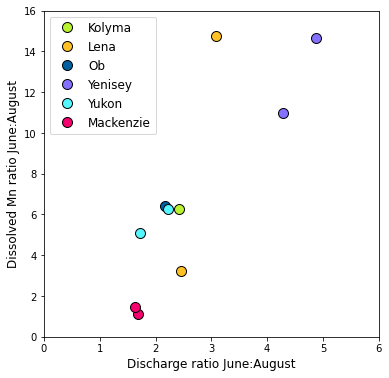

In [24]:
plot_QMn_ratio_subset()

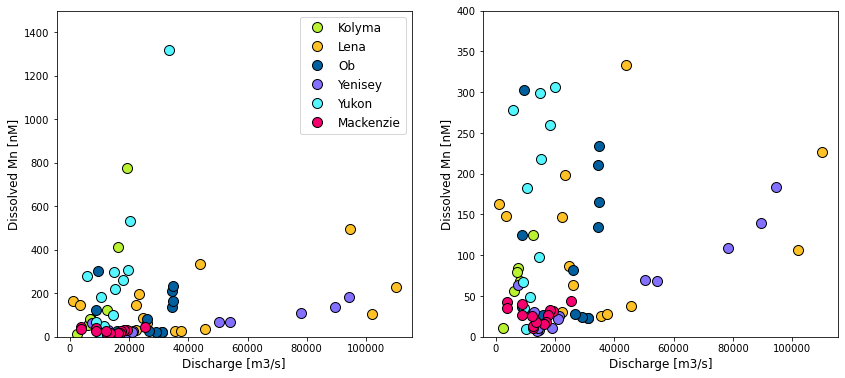

In [25]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

c_Mack = '#f5006e'; c_Kolyma  = '#b8f230'; c_Lena = '#ffc125';
c_Ob   = '#00609f'; c_Yenisey = '#8470ff'; c_Yukon = '#55f6ff';

for axis in ax:
    axis.plot(Kolyma_discharge[idx_Kolyma], Mn_Kolyma, '.', c=c_Kolyma, markersize=20, markeredgecolor='k', label='Kolyma')
    axis.plot(Lena_discharge[idx_Lena], Mn_Lena, '.', c=c_Lena, markersize=20, markeredgecolor='k', label='Lena')
    axis.plot(Ob_discharge[idx_Ob], Mn_Ob, '.', c=c_Ob, markersize=20, markeredgecolor='k', label='Ob')
    axis.plot(Yeni_discharge[idx_Yenisey], Mn_Yenisey, '.', c=c_Yenisey, markersize=20, markeredgecolor='k', label='Yenisey')
    axis.plot(Yukon_discharge[idx_Yukon], Mn_Yukon, '.', c=c_Yukon, markersize=20, markeredgecolor='k', label='Yukon')
    axis.plot(Mack_discharge[idx_Mack], Mn_Mack, '.', c=c_Mack, markersize=20, markeredgecolor='k', label='Mackenzie')
    
    axis.set_xlabel('Discharge [m3/s]', fontsize=12)
    axis.set_ylabel('Dissolved Mn [nM]', fontsize=12)

    
ax[0].set_ylim(0, 1500)
ax[1].set_ylim(0, 400)
ax[0].legend(fontsize=12)

Gradient in river discharge seasonality in model:

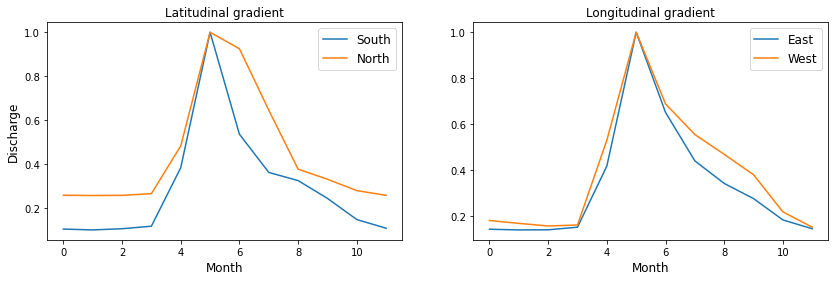

In [26]:
fig, ax = plt.subplots(1,2, figsize=(14,4))

ax[0].set_title('Latitudinal gradient', fontsize=12)
ax[0].set_xlabel('Month', fontsize=12)
ax[0].set_ylabel('Discharge', fontsize=12)
ax[0].plot(normalize(model_river[:,imin:imax,jmin:jmin+200].sum(axis=(1,2))), label='South')
ax[0].plot(normalize(model_river[:,imin:imax,jmax-200:jmax].sum(axis=(1,2))), label='North')
ax[0].legend(fontsize=12)

ax[1].set_title('Longitudinal gradient', fontsize=12)
ax[1].set_xlabel('Month', fontsize=12)
ax[1].plot(normalize(model_river[:,imin:imin+200,jmin:jmax].sum(axis=(1,2))), label='East')
ax[1].plot(normalize(model_river[:,imax-200:imax,jmin:jmax].sum(axis=(1,2))), label='West')
ax[1].legend(fontsize=12)

The river discharge seasonal cycles plotted below are based on the Arctic Great Rivers, lower down, I re-do it with smaller drainage basin Canadian Arctic Archipelago rivers

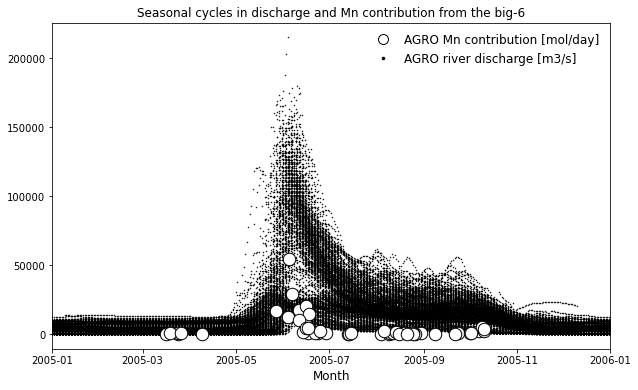

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

plot_seasonal_cycle(ax, QMn_Mack*1e-1   , Mack_dates_tracers, Mack_discharge, Mack_dates, discharge=True)
plot_seasonal_cycle(ax, QMn_Kolyma*1e-1 , Kolyma_dates_tracers, Kolyma_discharge, Kolyma_dates, discharge=True)
plot_seasonal_cycle(ax, QMn_Lena*1e-1   , Lena_dates_tracers, Lena_discharge, Lena_dates, discharge=True)
# plot_seasonal_cycle(ax, Mn_Ob     , Ob_dates_tracers) ### ignore b/c some weird points
plot_seasonal_cycle(ax, QMn_Yenisey*1e-1, Yenisey_dates_tracers, Yeni_discharge, Yeni_dates, discharge=True)
# plot_seasonal_cycle(ax, Mn_Yukon  , Yukon_dates_tracers) ### ignore b/c some weird points

ax.plot(0,0, '.', markersize=20, c='w', markeredgecolor='k', label='AGRO Mn contribution [mol/day]')
ax.plot(0,0, '.', markersize=5, c='k', label='AGRO river discharge [m3/s]')
    
ax.set_xlabel("Month", fontsize=12)
ax.set_xlim(dt.datetime(2005,1,1), dt.datetime(2006,1,1))
ax.set_title('Seasonal cycles in discharge and Mn contribution from the big-6')
ax.legend(frameon=False, fontsize=12)

Small Arctic rivers data:
https://www.r-arcticnet.sr.unh.edu/v4.0/Tiles/arctic4.html

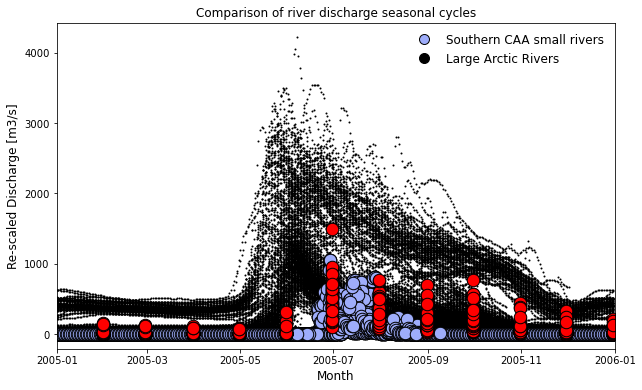

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

color_CAA = '#9eadfb'

plot_Qseasonal_cycle(ax, Mack_discharge*1e-1, Mack_dates)
plot_Qseasonal_cycle(ax, Kolyma_discharge*1e-1, Kolyma_dates)
plot_Qseasonal_cycle(ax, Lena_discharge*1e-2, Lena_dates)
plot_Qseasonal_cycle(ax, Yeni_discharge*1e-2, Yeni_dates)
plot_Qseasonal_cycle(ax, Allen_discharge[~np.isnan(Allen_discharge)]*1e1, Allen_dates[~np.isnan(Allen_discharge)], \
                     color=color_CAA, size=25)
plot_Qseasonal_cycle(ax, Mecham_discharge[~np.isnan(Mecham_discharge)]*1e1, Mecham_dates[~np.isnan(Mecham_discharge)], \
                     color=color_CAA, size=25)
plot_Qseasonal_cycle(ax, Marcil_discharge[~np.isnan(Marcil_discharge)]*1e1, Marcil_dates[~np.isnan(Marcil_discharge)], \
                     color=color_CAA, size=25)
plot_Qseasonal_cycle(ax, ellice_discharge, ellice_dates, color='r', size=25)
plot_Qseasonal_cycle(ax, burnside_discharge, burnside_dates, color='r', size=25)
plot_Qseasonal_cycle(ax, coppermine_discharge, coppermine_dates, color='r', size=25)

ax.plot(0,0, '.', markersize=20, c=color_CAA, markeredgecolor='k', label='Southern CAA small rivers')
ax.plot(0,0, '.', markersize=20, c='k', label='Large Arctic Rivers')
    
ax.set_ylabel('Re-scaled Discharge [m3/s]', fontsize=12)
ax.set_xlabel("Month", fontsize=12)
ax.set_xlim(dt.datetime(2005,1,1), dt.datetime(2006,1,1))
ax.set_title("Comparison of river discharge seasonal cycles")
ax.legend(frameon=False, fontsize=12)

# Create new forcing method:

In [27]:
rclass      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/river_class-202005.nc','r')
river_class = rclass.variables['rclass']
river_class = np.array(river_class)

In [33]:
def runoff_scaling(Q_river):
    scaling_factor = np.zeros_like(Q_river)
    
    # Maximum annual discharge for each river:
    Q_ma_river = np.ma.masked_where(Q_river<=0, Q_river) # masked array where runoff is zero
    Q_ma_max   = np.ma.max(Q_ma_river[:,:,:], axis=0)    # highest season flow
    Q_ma_min   = np.ma.min(Q_ma_river[:,:,:], axis=0)    # low season flow
    Q_ma_max [Q_ma_max == 0]  = np.nan
    
    # Scaling factor is 1280 at peak discharge (Colombo et al, 2019) and should be 1 during low flow.
    # "high flow concentrations are 1280% higher than low flow Mn concentrations"
    scaling_factor = 12.8*(Q_ma_river - Q_ma_min)/(Q_ma_max - Q_ma_min)
    scaling_factor = scaling_factor + 1
    
    # where there is no river runoff, the scaling factor should be zero
    scaling_factor[:,np.isnan(Q_ma_max)] = 0.0
    
    return scaling_factor

In [34]:
river_scaling = runoff_scaling(model_river)

In [37]:
# if we assume that the rivers were sampled during low flow season, we can apply the scaling directly to it
dMn_glacier_characteristic     = 164e-9   * river_scaling 
dMn_continental_characteristic = 29.8e-9  * river_scaling
dMn_other_characteristic       = 2.2e-9   * river_scaling 

SPM_glacier_characteristic     = 261e-6   * river_scaling
SPM_continental_characteristic = 1.196e-5 * river_scaling
SPM_other_characteristic       = 4.08e-6  * river_scaling

In [38]:
dMn_rivers = np.zeros((12, river_class.shape[0], river_class.shape[1]))
SPM_rivers = np.zeros((12, river_class.shape[0], river_class.shape[1]))

for month in range(0,12):  
    
    dMn_rivers[month,:,:][river_class==1.0] = dMn_glacier_characteristic[month][river_class==1.0]
    dMn_rivers[month,:,:][river_class==2.0] = dMn_continental_characteristic[month][river_class==2.0]
    dMn_rivers[month,:,:][river_class==3.0] = dMn_other_characteristic[month][river_class==3.0]
    dMn_rivers[month,:,:][river_class==4.0] = dMn_other_characteristic[month][river_class==4.0]
    
    SPM_rivers[month,:,:][river_class==1.0] = SPM_glacier_characteristic[month][river_class==1.0]
    SPM_rivers[month,:,:][river_class==2.0] = SPM_continental_characteristic[month][river_class==2.0]
    SPM_rivers[month,:,:][river_class==3.0] = SPM_other_characteristic[month][river_class==3.0]
    SPM_rivers[month,:,:][river_class==4.0] = SPM_other_characteristic[month][river_class==4.0]
    
#     save_file(month, SPM_rivers, dMn_rivers)

Text(0.5, 0.98, 'Mean river Mn forcing climatology')

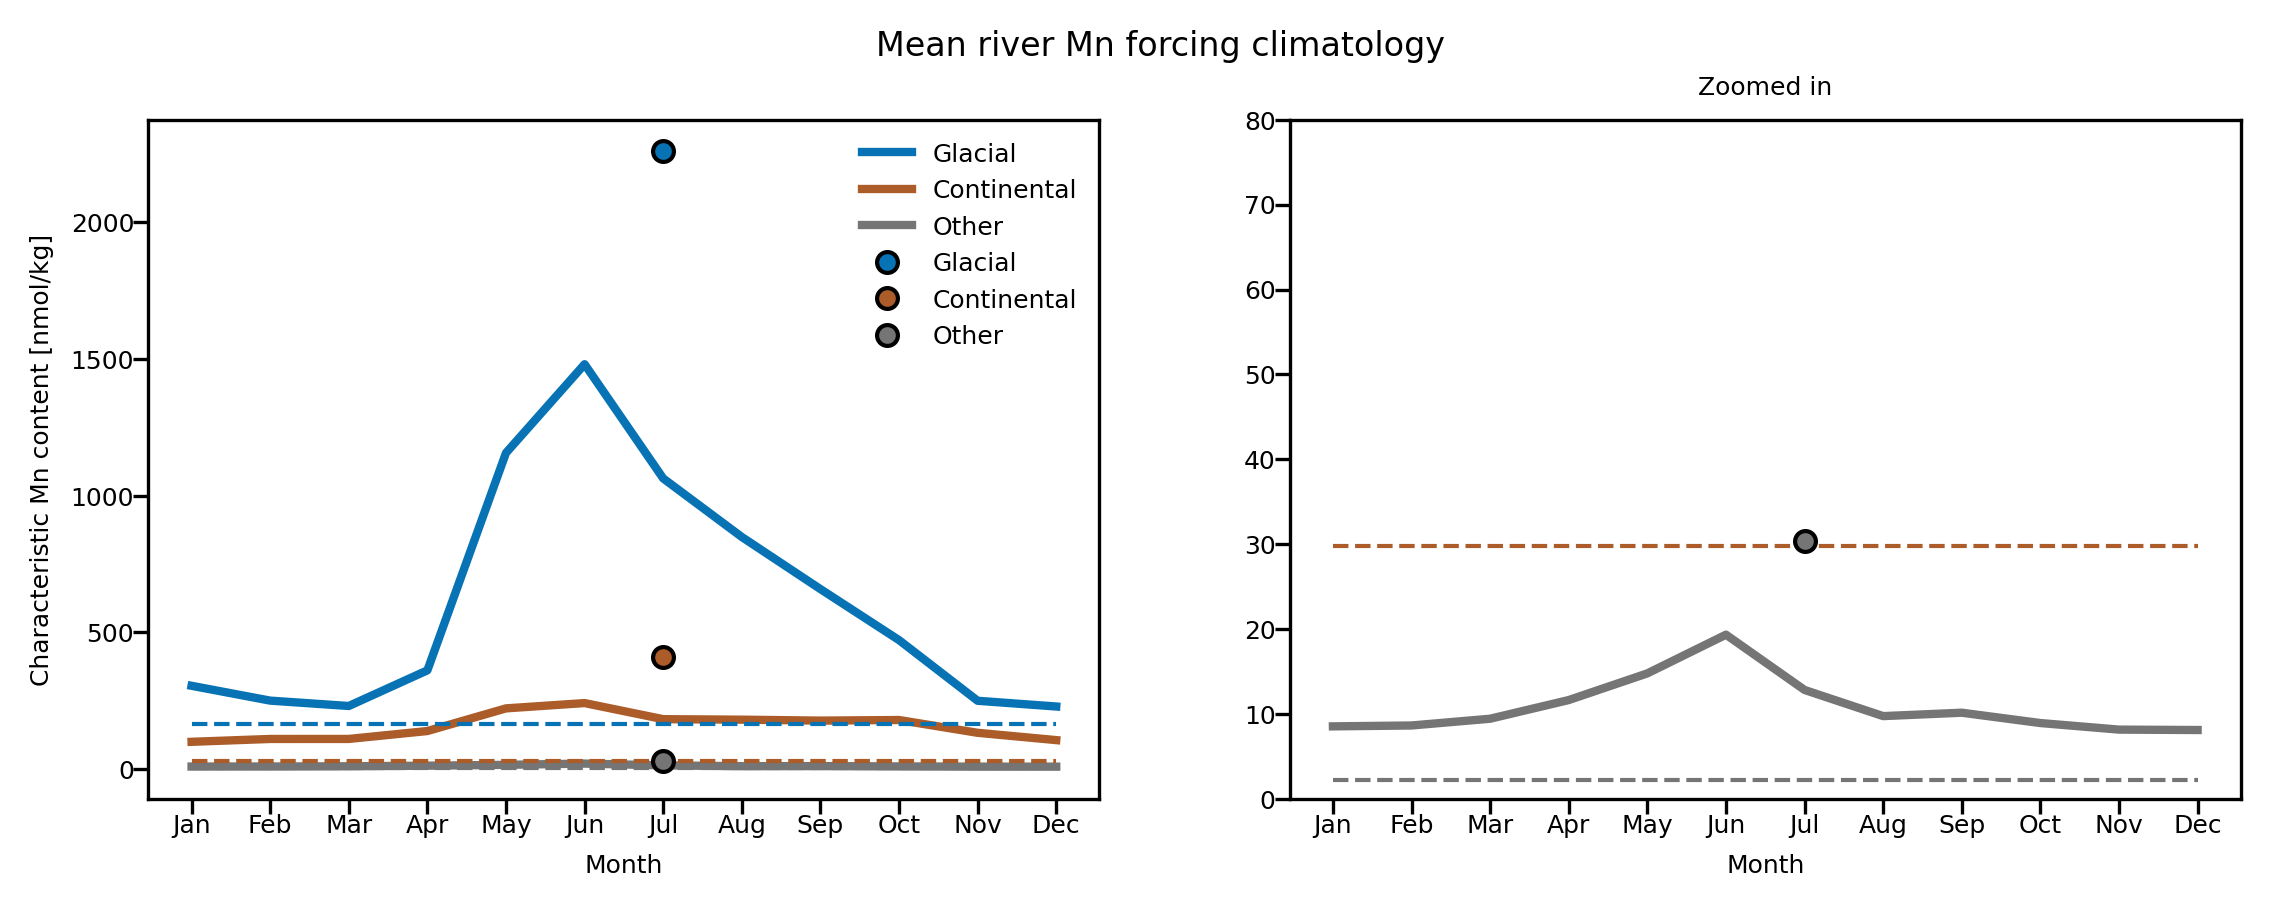

In [44]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(1,2, figsize=(9,3), dpi=300)

for axis in ax.ravel():
    axis.tick_params(axis='both', labelsize=6, pad=-0.1)

    axis.plot(months, np.mean(dMn_rivers[:,river_class==1.0], axis=1)*1e9, '-', linewidth=2.0, c=color_glac, label='Glacial')
    axis.plot(months, np.mean(dMn_rivers[:,river_class==2.0], axis=1)*1e9, '-', linewidth=2.0, c=color_cont, label='Continental')
    axis.plot(months, np.mean(dMn_rivers[:,river_class==3.0], axis=1)*1e9, '-', linewidth=2.0, c=color_other, label='Other')

    axis.plot(months, np.ones(len(months))*164, '--', linewidth=1.0, c=color_glac)
    axis.plot(months, np.ones(len(months))*29.8, '--', linewidth=1.0, c=color_cont)
    axis.plot(months, np.ones(len(months))*2.2, '--', linewidth=1.0, c=color_other)

    axis.plot(6, np.max(dMn_rivers[:,river_class==1.0])*1e9, '.', c=color_glac, label='Glacial', markeredgecolor='k', markersize=10)
    axis.plot(6, np.max(dMn_rivers[:,river_class==2.0])*1e9, '.', c=color_cont, label='Continental', markeredgecolor='k', markersize=10)
    axis.plot(6, np.max(dMn_rivers[:,river_class==3.0])*1e9, '.', c=color_other, label='Other', markeredgecolor='k', markersize=10)

    axis.set_xlabel('Month', fontsize=6)
    
ax[0].set_ylabel('Characteristic Mn content [nmol/kg]', fontsize=6)
ax[0].legend(frameon=False, fontsize=6)
ax[1].set_ylim([0,80])
ax[1].set_title('Zoomed in', fontsize=6)
fig.suptitle('Mean river Mn forcing climatology', fontsize=8)

Text(0.5, 0.98, 'Example river Mn forcing climatology')

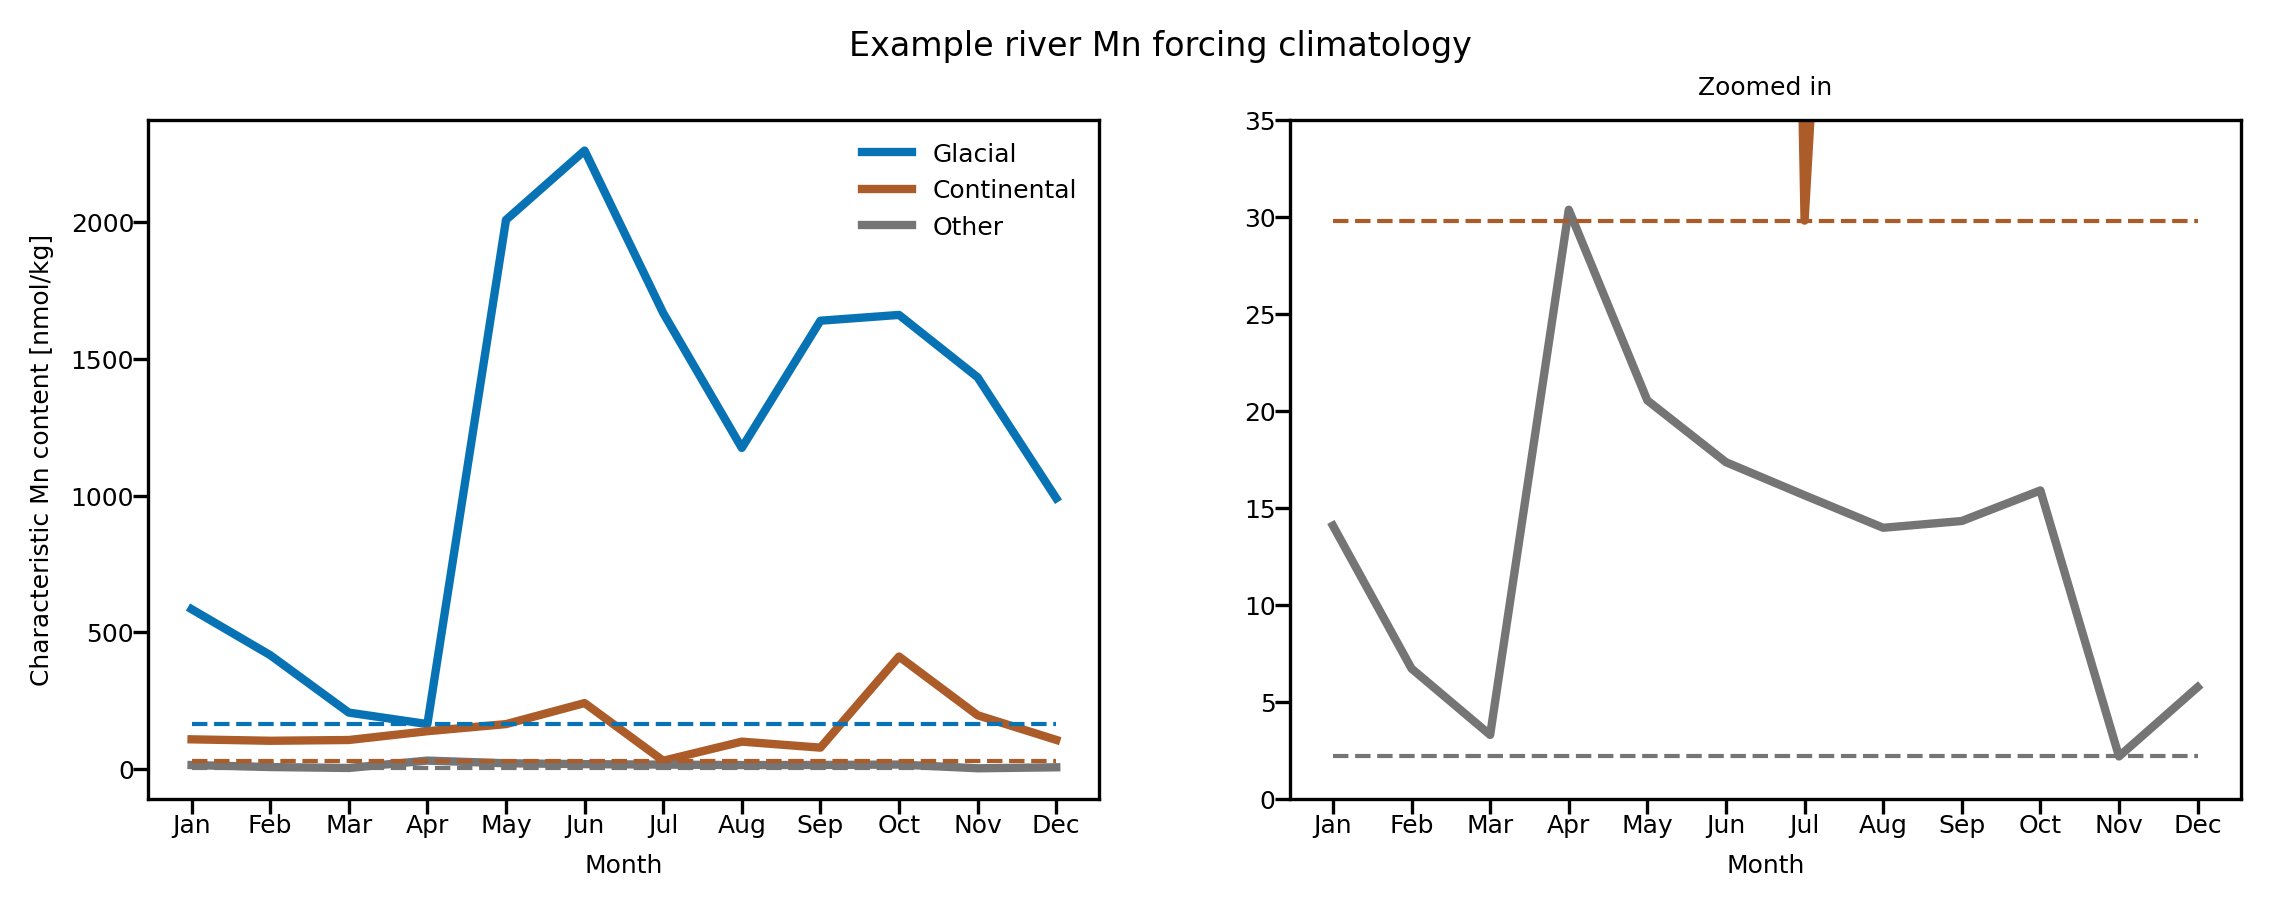

In [45]:
fig, ax = plt.subplots(1,2, figsize=(9,3), dpi=300)

for axis in ax.ravel():
    axis.tick_params(axis='both', labelsize=6, pad=-0.1)

    axis.plot(months, dMn_rivers[:,1045,1080]*1e9        , '-', linewidth=2.0, c=color_glac , label='Glacial')
    axis.plot(months, dMn_rivers[:,imin+699,jmin+323]*1e9, '-', linewidth=2.0, c=color_cont , label='Continental')
    axis.plot(months, dMn_rivers[:,8,1332]*1e9           , '-', linewidth=2.0, c=color_other, label='Other')

    axis.plot(months, np.ones(len(months))*164, '--', linewidth=1.0, c=color_glac)
    axis.plot(months, np.ones(len(months))*29.8, '--', linewidth=1.0, c=color_cont)
    axis.plot(months, np.ones(len(months))*2.2, '--', linewidth=1.0, c=color_other)

    axis.set_xlabel('Month', fontsize=6)
    
ax[0].set_ylabel('Characteristic Mn content [nmol/kg]', fontsize=6)
ax[0].legend(frameon=False, fontsize=6)
ax[1].set_ylim([0,35])
ax[1].set_title('Zoomed in', fontsize=6)
fig.suptitle('Example river Mn forcing climatology', fontsize=8)

In [55]:
def save_file(month, SPM_rivers, dMn_rivers):
    file_write = xr.Dataset(
        {'spm_rivers': (("y","x"), SPM_rivers), 
         'dmn_rivers': (("y","x"), dMn_rivers)}, 
        coords = {
            "y": np.zeros(2400),
            "x": np.zeros(1632),
        },
    )

    file_write.to_netcdf(f'/ocean/brogalla/GEOTRACES/data/paper2-forcing-files/river_seasonal_m{month:02}.nc')
    
    return

In [56]:
[save_file(month, SPM_rivers[month-1,:,:], dMn_rivers[month-1,:,:]) for month in range(1,13)]

[None, None, None, None, None, None, None, None, None, None, None, None]